# source

https://fastaudio.github.io/Introduction%20to%20Audio/

# Introduction to Audio For FastAI Students

In [16]:
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

torchaudio.set_audio_backend("sox_io")

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> This guide will assume absolutely zero understanding of audio. There are lots of good resources out there, but nothing that really walks you through the basics of audio all the way up to what it takes to train state of the art models. If you have some experience, or find this guide too slow paced, check out the [FastAI Audio Thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123) for a list of resources we've found helpful. Full disclosure, I am not an audio engineer. There will be inaccuracies in this guide, please message me [on twitter](https://twitter.com/MadeUpMasters) or [FastAI forums](https://forums.fast.ai/u/MadeUpMasters/) with any corrections or suggestions and I'll happily change them and credit you here.
> 
> Like deep learning, audio processing has many hyperparameters and concepts that can be confusing, but will play an essential role in training models. The goal of this guide is to introduce you to some of them, show you what tweaking them does, and give you a basic understanding of what they represent and why they exist. If you don't care about the details, check out our other starter notebooks.
> 
> First let's grab our data.

In [17]:
speakers = untar_data(URLs.SAMPLE_SPEAKERS10)

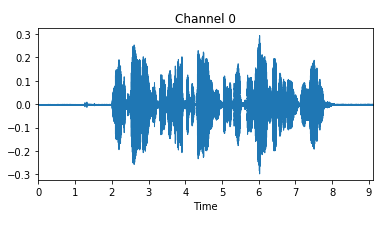

In [18]:
audio_files = get_audio_files(speakers)
example = audio_files[0]
audio = AudioTensor.create(example)
audio.show()

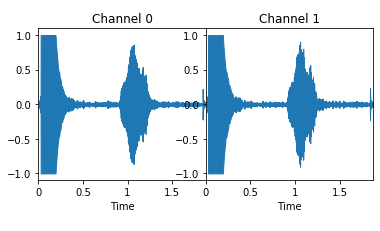

In [19]:
audio_zeor = AudioTensor.create(Path('/home/explore/git/guillaume/zoe/data/numbers/audio/0.mp3'))
audio_zeor.show()

# Basics of Librosa, Audio Signals, and Sampling

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> In fastaudio, we use torchaudio for a lot of our io operations (loading the audio), librosa is another alternative that is commonly used in audio processing. To read an audio for processing, just pass in a filepath to torchaudio

In [20]:
import torchaudio

In [21]:
y, sr = torchaudio.load(example)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Most libraries will pass back a tuple with signal (y) and a sample rate (sr).

In [47]:
def get_signal_info(audio_sample):
    y, sr = torchaudio.load(audio_sample)
    print("Sample rate  :", sr)
    print("Number of channels:", y.shape[0])
    print("Signal Length:", y.shape[1])
    print("Duration     :", y.shape[1]/sr, "seconds")
    return y, sr

In [48]:
_,_ = get_signal_info(example)

Sample rate  : 16000
Number of channels: 1
Signal Length: 145920
Duration     : 9.12 seconds


In [63]:
example_zero = Path('/home/explore/git/guillaume/zoe/data/numbers/audio/0.mp3')
y, sr = get_signal_info(Path('/home/explore/git/guillaume/zoe/data/numbers/audio/0.mp3'))

Sample rate  : 44100
Number of channels: 2
Signal Length: 82908
Duration     : 1.88 seconds


In [64]:
# en monochannel: y = y.numpy()[0]
y = np.mean(y.numpy(), axis=0)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Audio is a continuous wave that is "sampled" by measuring the amplitude of the wave at a given time. How many times you sample per second is called the "sample rate" and can be thought of as the resolution of the audio. The higher the sample rate, the closer our discrete digital representation will be to the true continuous sound wave, but there is a point of diminishing returns so bigger isn't always better. Sample rates generally range from 8000-44100 but can go higher or lower.
> 
> In our example, the audio was sampled 44100 times per second, so our data is a 1 dimensional tensor with length 44100\*time in seconds = 82908 samples
> 
> Our signal is just a numpy array with the amplitude of the wave

In [65]:
print("Type  :", type(y))
print("Signal: ", y)
print("Shape :", y.shape)


Type  : <class 'numpy.ndarray'>
Signal:  [ 0.0000000e+00 -7.4505806e-09 -7.4505806e-09 ...  2.8504282e-03
 -2.1203049e-03  3.7897099e-03]
Shape : (82908,)


In [66]:
Audio(y, rate=sr)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Before running and listening to the cells below, think about the concept of sampling rate and try to predict what effect the varying sample rates will have

In [67]:
Audio(y, rate=sr/2)

In [68]:
Audio(y, rate=sr*2)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Here we can experiment with different sampling rates using the librosa load method.

In [70]:
y_new, sr_new = librosa.load(example_zero, sr=sr*2)
Audio(y_new, rate=sr_new)

/home/explore/miniconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [71]:
y_new, sr_new = librosa.load(example_zero, sr=sr/2)
Audio(y_new, rate=sr_new)

/home/explore/miniconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# Waveforms. Amplitude vs Magnitude

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Let's check out the waveform of our audio clip

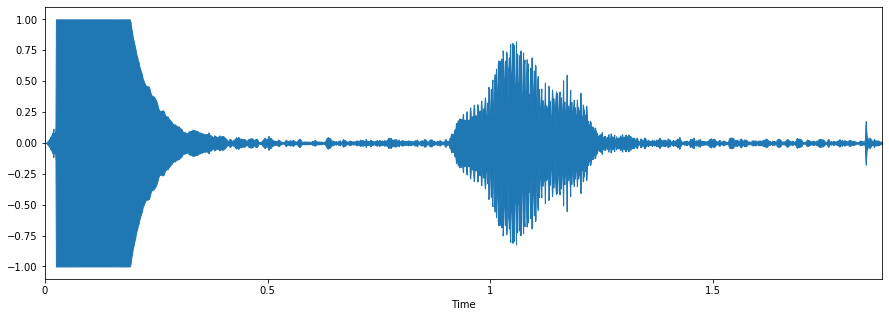

In [72]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Note that there is nothing special about this graph except that the x-axis has been converted to time using our sample rate. If we plotted in matplotlib with plt.plot(y), we would get the same figure, but with sample number on the x-axis instead of seconds.
> 
> Amplitude and magnitude are often confused, but the difference is simple. Amplitude of a wave is just the distance, positive or negative, from the equilibrium (zero in our case), and magnitude is the absolute value of the amplitude. In audio we sample the amplitude so our signal can have both positive and negative values.

# Frequency and Pitch

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Most of us remember frequency from physics as cycles per second of a wave. It's the same for sound, but really hard to see in the above image. How many cycles are there? How can there be cycles if it's not regular? The reality is that sound is extremely complex, and the above recording of human speech is the combination of many different frequencies added together. To talk about frequency and pitch, it's easier to start with a pure tone, so let's make one.
> 
> Human hearing ranges from 20hz to 20,000hz, hz=hertz=cycles per second. The higher the frequency, the more cycles per second, and the "higher" the pitch sounds to us. To demonstrate, let's make a sound at 500hz, and another at 5000hz.

In [77]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)


In [78]:
Audio(clip_500hz, rate=sr)

In [79]:
Audio(clip_5000hz, rate=sr)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> 500 cycles per second, 16000 samples per second, means 1 cycle = 16000/500 = 32 samples, let's see 2 cycles

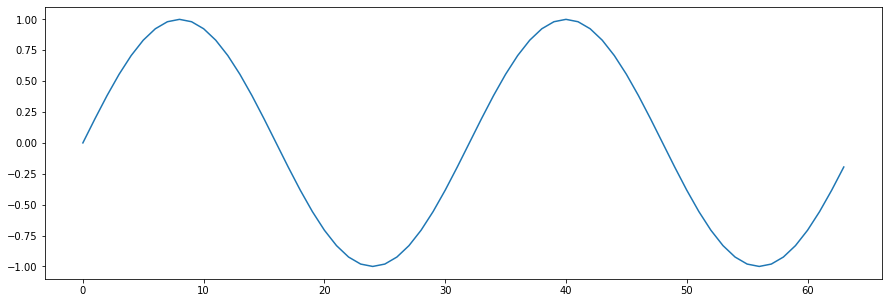

In [80]:
plt.figure(figsize=(15, 5))
plt.plot(clip_500hz[0:64])

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Below is 5000hz from the same vantage point, this is what is meant by higher frequency. Of course in real life this is a continuous wave, but since our digital representation is discrete, capturing it starts to break down for high frequencies if we don't increase our sample rate. The limitations of digital representations of audio are laid out by Nyquist Theorem, which we discuss later.

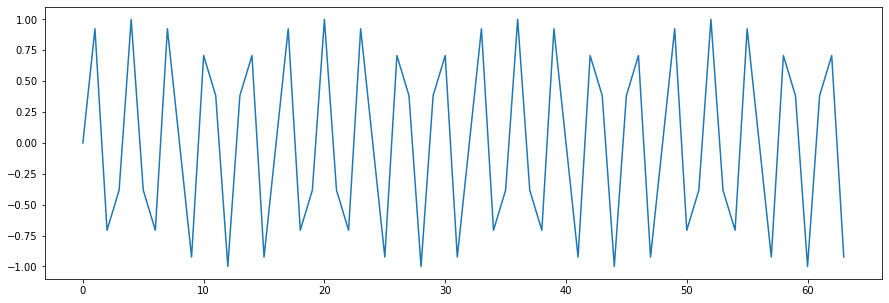

In [81]:
plt.figure(figsize=(15, 5))
plt.plot(clip_5000hz[0:64])

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> So if that's frequency, what is pitch? Pitch is a musical term that means the human perception of frequency. This concept of human perception instead of actual values seems vague and non-scientific, but it is hugely important for machine learning because most of what we're interested in, speech, sound classification, music...etc are inseparable from human hearing and how it functions. Let's do an experiment and increase the frequency of the above tones by 500hz each and see how much this moves our perception of them

In [82]:
clip_500_to_1000 = np.concatenate([make_tone(500), make_tone(1000)])
clip_5000_to_5500 = np.concatenate([make_tone(5000), make_tone(5500)])


In [83]:
# first half of the clip is 500hz, 2nd is 1000hz
Audio(clip_500_to_1000, rate=sr)

In [84]:
# first half of the clip is 5000hz, 2nd is 5500hz
Audio(clip_5000_to_5500, rate=sr)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Notice that the pitch of the first clip seems to change more even though they were shifted by the same amount. This makes intuitive sense as the frequency of the first was doubled and the frequency of the second only increased 10%. Like other forms of human perception, hearing is not linear, it is logarithmic. This will be important later as the range of frequencies from 100-200hz convey as much information to us as the range from 10,000-20,000hz. If we don't account for this in our data's representation, the lower frequency info will be squished out of existence.
> 
> Fortunately, scientists have thought about this problem and came up with something called the mel scale.

# Mel Scale

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> The mel scale is a human-centered metric of audio perception that was developed by asking participants to judge how far apart different tones were. Here is a formula from mel-scale's wikipedia page that you will never need, but might like to see.
> 
> And here is a table of values that represent some examples of frequency in hz and their corresponding mel values. Note: Someone please tell me how to make this table horizontal and maintain the headers :)
> 
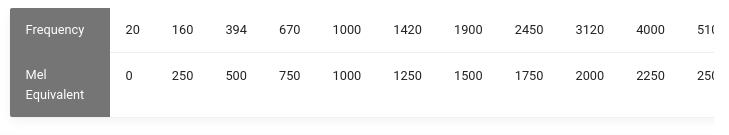
> 
> When we visually represent audio using spectrograms, we will use the mel scale instead of frequency on our y-axis, so that our data is reshaped to mirror human perception. **If you're getting bored, hang in there, because we are so close to the fun part (spectrograms)**, but there is one last piece to human hearing puzzle we need to deal with.

# Decibels

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Just like frequency, human perception of loudness occurs on a logarithmic scale. A constant increase in the amplitude of a wave will be perceived differently if the original sound is soft or loud.
> 
> Decibels measure the ratio of power between 2 sounds, with the main idea being that each 10x increase in the energy of the wave (multiplicative) results in a 10dB increase in sound (additive). Thus something that is 20dB louder has 100x (10\*10) the amount of energy, something that is 25dB louder has (10^2.5) = 316.23x more energy.
> 
> The lowest audible sound, near absolute silence, is 0dB and we refer to other sounds based on how many times more energy they have than a 0dB sound. A dishwasher is ~30dB, or 10^3 = 1000x louder. Here is a nice chart taken from: https://boomspeaker.com/noise-level-chart-db-level-chart/
> 
> ![image.png](https://fastaudio.github.io/Introduction%20to%20Audio/image.png)
> 
> The range of human perception is vast, from a base of 0dB up to 100dB (an amount that will damage your hearing), is a range of 10^10, or 10,000,000,000x. A doubling of energy will only increase the dB level by ~3dB. If we don't use a logarithmic scale, we would squish whispers and rustling leaves, and even normal conversation out of existence. Thus is it is important that we measure our spectrograms be on the decibel scale for most of our applications.
> 
> Deep dive for decibel scale: http://www.animations.physics.unsw.edu.au/jw/dB.htm

# Spectrogram as a Visual Representation of Audio

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Remember how it was impossible to see the smooth cycles and frequencies in the raw waveform graph of our first audio clip? A spectrogram is an almost magical way of breaking a complex signal apart into it's constituent frequencies, and then representing that as an image. Before we get into how this actually happens, let's see what they look like and how to generate and play with them, because this is more important for training your models than actually understanding what a fourier transform is and how it works.
> 
> Librosa allows us to generate a spectrogram with the melscale directly using `librosa.feature.melspectrogram`. To demonstrate why the previous discussion of melscale and decibels was necessary, we'll first display a raw spectrogram with `librosa.stft`, then a melspectrogram, and then finally a melspectrogram on the decibel scale.
> 
> sg = spectrogram, this is a raw energy spectrogram. stft = short-time fourier transform. stft returns a complex result with a real component, the magnitude, and a complex part, the phase. The complex part is typically not used in machine learning applications, but there are a few papers that suggest it is useful so you may want to experiment. For now we will discard it.

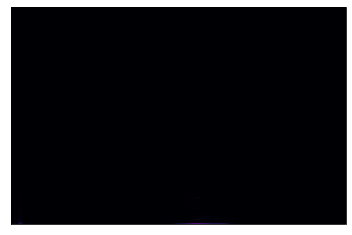

In [86]:
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
display(librosa.display.specshow(sg_mag))


[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Next we use the mel-scale instead of raw frequency. `librosa.feature.melspectrogram` can take either a raw spectrogram and convert to mel-scale, or a raw signal, compute the spectrogram, and then convert. We will use what we generated in the above cell, but usually you'll want to pass the signal directly.

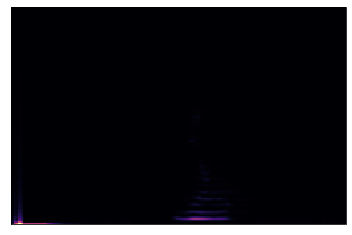

In [88]:
sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=sr)
display(librosa.display.specshow(sg1))

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> It's a little better, but most of the information is still zeros, and we know our original signal has lots of info, so we must be throwing away too much. Converting to the decibel scale using `librosa.amplitude_to_db` will fix this.

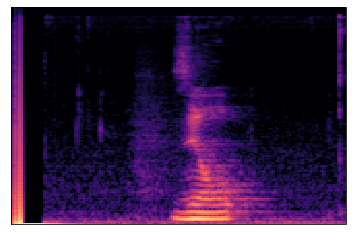

In [89]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2)


[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Okay, this is starting to look like reasonable. But what does any of this mean? In the next section, we'll add on some axes and a colorbar legend and then look at the underlying data structure and see what we're dealing with

# What's Inside a Spectrogram?

Text(0.5, 1.0, 'Mel spectrogram')

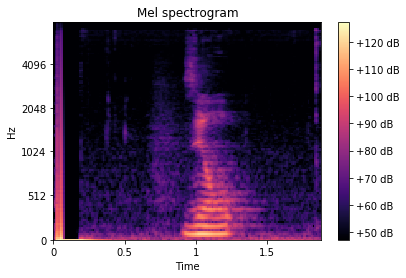

In [94]:
# code adapted from the librosa.feature.melspectrogram documentation
librosa.display.specshow(sg2, sr=44100, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')


[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Now we can see, just like when we plotted the audio, the x-axis is time, but now, instead of the amplitude of the wave on the y-axis, we have the frequency. The y-axis is also no longer linear, each new tick doubles the frequency, with a max frequency, or fmax of 8000. Also, this isn't a line graph like the raw waveform, instead of a single value at each timepoint on our x-axis, we have many. Every point in the square represents the energy at the **frequency of it's y-coordinate at the time of it's x-coordinate**.
> 
> Take the point 1.0 seconds in at 256hz, it appears to be cream colored meaning the energy at that point is somewhere around 90-100db. Meanwhile at that same time, 1024hz appears to be purple and have about 70dB of energy. That means that at t = 1.0 seconds, the sound with 256hz is around 100 times louder than sound at 1024hz. 10^((90-70)/10) = 10^2 = 100.
> 
> Let's check out the min, max, and mean of the spectrogram. Remember, the units for these are all decibels.

In [95]:
sg2.min(), sg2.max(), sg2.mean()

(47.15397, 127.15397, 56.858994)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> So it looks like spectrograms have a built in min, mean, and max, that's nice. Let's see what type of object a spectrogram really is so we can see what else we can do.

In [96]:
print(type(sg2))
sg2.shape

<class 'numpy.ndarray'>


(128, 162)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> Spectrograms become a lot less magical and a lot easier to work with when you realize they're just 2d numpy arrays. We no longer have to remember and call random functions like librosa.display.specshow, with a little tinkering (converting to pytorch, and adding a unit axis) we can just use fastai's `Image()`

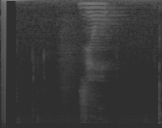

In [97]:
from torchvision.transforms.functional import to_pil_image
to_pil_image(torch.tensor(sg2).unsqueeze(0)/255)

[Introduction to Audio - Fastaudio](https://fastaudio.github.io/Introduction%20to%20Audio/)

> `unsqueeze(0)` adds a single axis in pos 0 so we go from 128x103 to 1x128x103. Images in fastai have 3 dimensions, the first, a channel dimension 1 for monochrome images, 3 for rgb.